In [1]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!unzip "/content/star-wars.zip" -d "/content/"

Archive:  /content/star-wars.zip
   creating: /content/star-wars/
   creating: /content/star-wars/0001/
  inflating: /content/star-wars/0001/001.jpg  
  inflating: /content/star-wars/0001/002.jpg  
  inflating: /content/star-wars/0001/003.jpg  
  inflating: /content/star-wars/0001/004.jpg  
  inflating: /content/star-wars/0001/005.jpg  
  inflating: /content/star-wars/0001/006.jpg  
  inflating: /content/star-wars/0001/007.jpg  
  inflating: /content/star-wars/0001/008.jpg  
  inflating: /content/star-wars/0001/009.jpg  
  inflating: /content/star-wars/0001/010.jpg  
  inflating: /content/star-wars/0001/011.jpg  
  inflating: /content/star-wars/0001/012.jpg  
   creating: /content/star-wars/0002/
  inflating: /content/star-wars/0002/001.jpg  
  inflating: /content/star-wars/0002/002.jpg  
  inflating: /content/star-wars/0002/003.jpg  
  inflating: /content/star-wars/0002/004.jpg  
  inflating: /content/star-wars/0002/005.jpg  
  inflating: /content/star-wars/0002/006.jpg  
  inflating:

In [3]:
BASE_DIR = 'star-wars/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS",
         "KYLO REN", "THE MANDALORIAN", "CARA DUNE", "KLATOOINIAN RAIDER 1",
         "KLATOOINIAN RAIDER 2", "JANNAH", "HAN SOLO", "DARTH VADER",
         "ANAKIN SKYWALKER", "EMPEROR PALPATINE", "OBI-WAN KENOBI"]

tf.random.set_seed(1)

In [4]:
# content -> star-wars -> 0001, 0002, ... 0016, train, test, val

if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [5]:
# Move the image files

orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/", "0006/", "0007/", "0008/", "0009/", "0010/",
                 "0011/", "0012/", "0013/", "0014/", "0015/", "0016/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

12 7 3 2
12 7 3 2
12 7 3 2
13 8 3 2
14 8 4 2
10 6 3 1
8 5 2 1
8 5 2 1
8 5 2 1
8 5 2 1
8 5 2 1
8 5 2 1
9 5 2 2
9 5 2 2
10 6 3 1
9 5 2 2


In [6]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
val_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

In [7]:
train_batches = train_gen.flow_from_directory(
                'star-wars/train',
                target_size=(256, 256),
                class_mode='sparse',
                batch_size=4,
                shuffle=True,
                color_mode='rgb',
                classes=names
)

test_batches = test_gen.flow_from_directory(
                'star-wars/test',
                target_size=(256, 256),
                class_mode='sparse',
                batch_size=4,
                shuffle=True,
                color_mode='rgb',
                classes=names
)

val_batches = val_gen.flow_from_directory(
                'star-wars/val',
                target_size=(256, 256),
                class_mode='sparse',
                batch_size=4,
                shuffle=True,
                color_mode='rgb',
                classes=names
)

Found 94 images belonging to 16 classes.
Found 24 images belonging to 16 classes.
Found 40 images belonging to 16 classes.


In [20]:
train_batches[0][0].shape

(4, 256, 256, 3)

In [22]:
train_batches[0][1]

array([ 8.,  8.,  4., 12.], dtype=float32)

In [23]:
test_batches[0][0].shape

(4, 256, 256, 3)

In [24]:
test_batches[0][1]

array([ 8.,  3.,  6., 13.], dtype=float32)

In [26]:
train_batch = train_batches[0]
test_batch = test_batches[0]

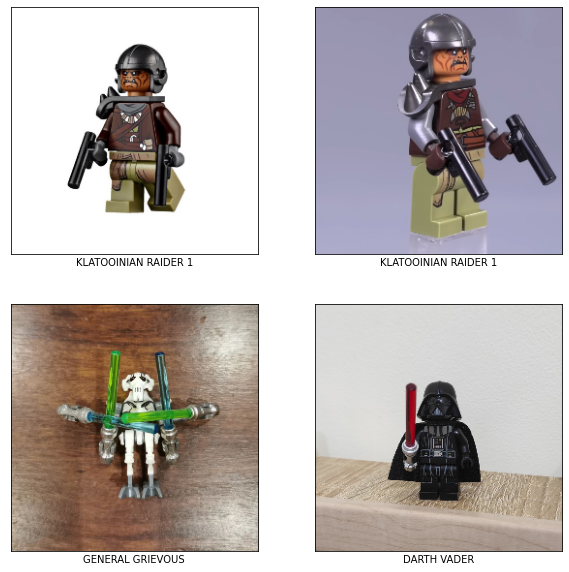

In [27]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(train_batch)

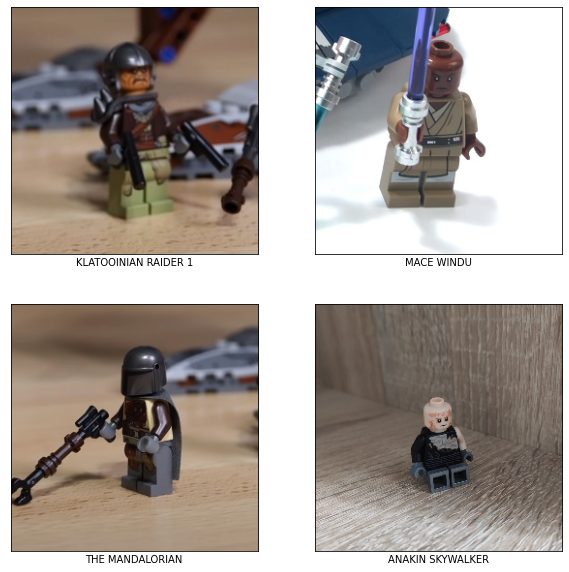

In [28]:
show(test_batch)

In [21]:
model = keras.models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(train_batches[0][0].shape[1:])))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 256)      

In [23]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']

In [24]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [25]:
epochs=50

In [26]:
# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

In [27]:
history = model.fit(train_batches, validation_data=val_batches,
                    callbacks=[early_stopping],
                      epochs=epochs, verbose=1)

Epoch 1/50
24/24 [==============================] - 4s 117ms/step - loss: 7.0603 - accuracy: 0.0532 - val_loss: 2.7725 - val_accuracy: 0.0750
Epoch 2/50
24/24 [==============================] - 2s 82ms/step - loss: 2.7698 - accuracy: 0.0957 - val_loss: 2.7669 - val_accuracy: 0.0750
Epoch 3/50
24/24 [==============================] - 2s 82ms/step - loss: 2.7724 - accuracy: 0.0532 - val_loss: 2.7713 - val_accuracy: 0.0750
Epoch 4/50
24/24 [==============================] - 2s 84ms/step - loss: 2.8137 - accuracy: 0.0745 - val_loss: 2.7707 - val_accuracy: 0.0750
Epoch 5/50
24/24 [==============================] - 2s 83ms/step - loss: 2.7713 - accuracy: 0.0851 - val_loss: 2.7700 - val_accuracy: 0.0750
Epoch 6/50
24/24 [==============================] - 2s 82ms/step - loss: 2.7701 - accuracy: 0.0851 - val_loss: 2.7686 - val_accuracy: 0.0750
Epoch 7/50
24/24 [==============================] - 2s 82ms/step - loss: 2.7659 - accuracy: 0.1170 - val_loss: 2.7659 - val_accuracy: 0.0750
Epoch 8/50
2

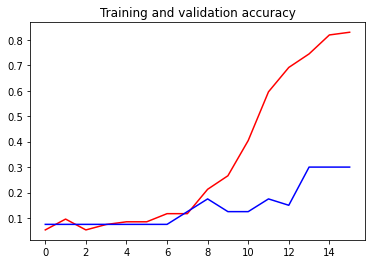

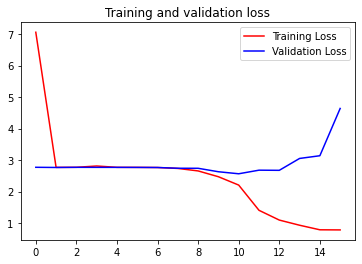

In [28]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()